# **Import Library**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
pip install tensorflow==2.15

In [ ]:
# library untuk menangani data
import zipfile
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

In [ ]:
# Path ke file zip di Google Drive
zip_path = '/content/drive/MyDrive/learning-agency-lab-automated-essay-scoring-2.zip'
extract_path = '/content/dataset'

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Memastikan bahwa file telah diekstrak
extracted_files = os.listdir(extract_path)
print("Files in extracted folder:", extracted_files)

# Cek apakah file yang dibutuhkan ada sebelum memuatnya
train_file = os.path.join(extract_path, 'train.csv')
test_file = os.path.join(extract_path, 'test.csv')
sample_submission_file = os.path.join(extract_path, 'sample_submission.csv')

if all(os.path.exists(file) for file in [train_file, test_file, sample_submission_file]):
    # Membaca dataset yang diekstraksi
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    sample_submission = pd.read_csv(sample_submission_file)


Files in extracted folder: ['test.csv', 'sample_submission.csv', 'train.csv']


In [ ]:
# Membagi train menjadi train_df dan valid_df
train_df, valid_df = train_test_split(
    train,
    test_size=0.2,  # Ukuran validasi (20%)
    stratify=train["score"]  # Stratifikasi berdasarkan kolom "score"
)

print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {valid_df.shape}")


Train set size: (13845, 3)
Validation set size: (3462, 3)


# **Exploratory Data Analysis**

## Informasi Dataset

{test/train}.csv
* essay_id: Pengenal unik untuk setiap esai.
* full_text: Teks esai.
* score: Skor esai dengan rentang 1-6.

sample_submission.csv : Sampel valid yang dimasukkan untuk prediksi.  

In [ ]:
print('train data shape:', train.shape )
train.head()

train data shape: (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
train.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [ ]:
train.isnull().sum()

,0
essay_id,0
full_text,0
score,0


In [ ]:
print('test data shape:', test.shape )
test.head()

test data shape: (3, 3)


,essay_id,full_text,clean_text
0,000d118,Many people have car where they live. The thin...,many people car live thing dont know use car a...
1,000fe60,I am a scientist at NASA that is discussing th...,scientist nasa discussing face mars explaining...
2,001ab80,People always wish they had the same technolog...,people always wish technology seen movies best...


In [ ]:
test.isnull().sum()

,0
essay_id,0
full_text,0


In [ ]:
sample_submission.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


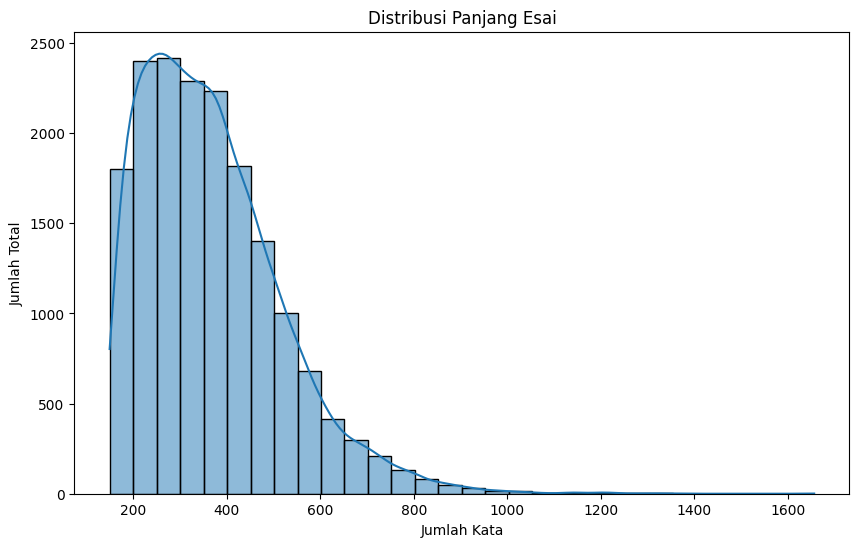

In [ ]:
# Menghitung panjang esai berdasarkan jumlah kata yang dipisahkan oleh spasi dalam setiap teks.
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(essay_lengths, bins=30, kde=True)
plt.title('Distribusi Panjang Esai')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Total')
plt.show()

In [ ]:
# Hitung jumlah kata pada setiap esai
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))

print(f"Minimum Panjang Esai: {essay_lengths.min()} kata")
print(f"Maximum Panjang Esai: {essay_lengths.max()} kata")
print(f"Rata-rata Panjang Esai: {essay_lengths.mean():.2f} kata")
print(f"Median Panjang Esai: {essay_lengths.median()} kata")
print(f"25th Persentil: {essay_lengths.quantile(0.25)} kata")
print(f"50th Persentil (Median): {essay_lengths.quantile(0.50)} kata")
print(f"75th Persentil: {essay_lengths.quantile(0.75)} kata")

Minimum Panjang Esai: 150 kata
Maximum Panjang Esai: 1656 kata
Rata-rata Panjang Esai: 368.35 kata
Median Panjang Esai: 345.0 kata
25th Persentil: 253.0 kata
50th Persentil (Median): 345.0 kata
75th Persentil: 452.0 kata


<ipython-input-13-17e5cb8ffaec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=train, palette='viridis')


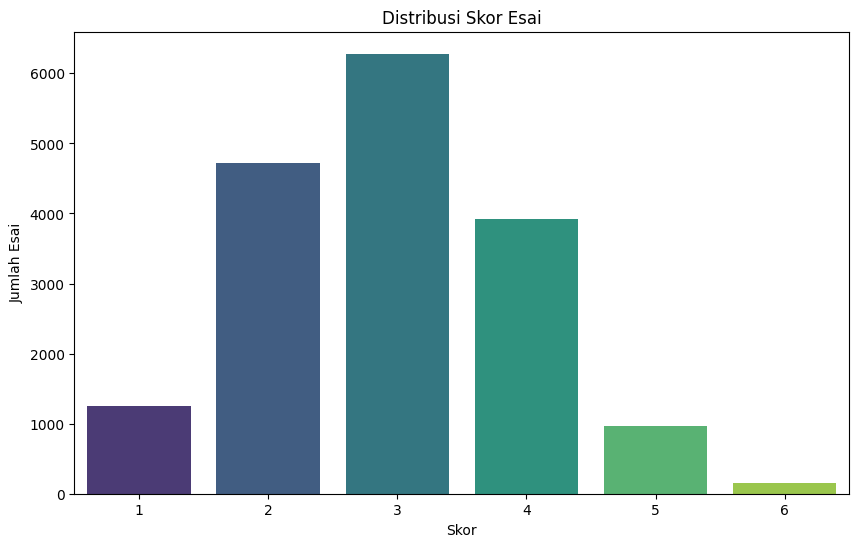

In [ ]:
# Distribusi skor esai
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=train, palette='viridis')
plt.title('Distribusi Skor Esai')
plt.xlabel('Skor')
plt.ylabel('Jumlah Esai')
plt.show()

In [ ]:
train['score'].value_counts()

,count
score,
3,6280
2,4723
4,3926
1,1252
5,970
6,156


In [ ]:
valid_df.head()

,essay_id,full_text,score
8129,7979641,I my name is Luke I am a seagoing cowboy. Bein...,2
7088,6a3ad47,Driverless cars next big thing ? Sergey Brian ...,2
16971,fae8a55,"In the article Driverless Cars Are Coming, the...",3
6014,5a0b24e,The author describes how a new technology call...,2
5947,59421c0,"Professor Thomas Huang, of the Beckman Insitut...",5


In [ ]:
train_df.head()

,essay_id,full_text,score
14808,da478ea,"A president election is great but, there are s...",5
11995,b06624a,I think you should join the Seagoing Cowboys. ...,2
14304,d2b91e5,Having a driverless car would be like having a...,3
4196,3def10f,The world of technology is developing to a hig...,3
2859,2aa79b2,I think the idea of Driverless cars isn't the ...,3


In [ ]:
train['full_text'].head()

,full_text
0,Many people have car where they live. The thin...
1,I am a scientist at NASA that is discussing th...
2,People always wish they had the same technolog...
3,"We all heard about Venus, the planet without a..."
4,"Dear, State Senator\n\nThis is a letter to arg..."


# **Preprocessing Data**

In [ ]:
# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

In [ ]:
# Implementasi pembersihan teks
train_df['clean_text'] = train_df['full_text'].apply(clean_text)
valid_df['clean_text'] = valid_df['full_text'].apply(clean_text)

In [ ]:
train_df['clean_text'].value_counts()

,count
clean_text,
people world like try new things everyday faced new different challenges car drives would trying something new extraordinary drive car drives question one greatest questions ask car drives could ask would open new doors ideas long car rides would drive could look scenery enjoy time family car drives would next step something amazing time cars become safer reliable would mean could go faster car running late work takes fifteen minutes get well anymore car would like car nascar could get destination instant car could drive would benefit lot people world reading said driveless car would use half fuel taxi car would waste money gas every week would help people even new drivers pay gas also means less pollution help people breathe easier automatic cars become reliable faster late pick kids car would get fast problem automatic taxi services great need across country people buy car people taxi car pick house take work taxi cars would never late since smart would never worry late also would take car wait someone come pick people would love experience taxi service would come pick would feel important become happier many wrecks happen year wreck year another car hitting thought would never happen started driving couple weeks later experience made safer driver still people get injured killed every week careless drivers automatic car would reduce amount fatal accidents thinking would onehundred percent safe car would great feeling adult could let kids go car wanted would know safe never wreck cars drive would great new experience years could tell grandchildren generation could finally drive selfdriving cars cars would benefit whole world positive way together make world better safer smarter cars new way living better way living humans since ancient times always wanted advance technology new car take us places never gone let us move go world selfdriving cars see take us,1
imagine would like use technology identify human emotions article making mona lisa smile informs us new method might beneficial teachers dr paul eckman creator facs facial action coding system used improved technology help establish connection computers able detect human emotions another man name prof thomas huang developed software working collaboration prof nicu sebe using computers help read emotional expressions students could valuable teaching improving education around world learning benifits computers detect emotions significant grasp system works process begins computer constructs computer model face fortyfour major muscles model must move like human muscles dr eckman classified six basic emotions happiness surprise anger disgust fear sadness moreover emotions claims associated characteristic movements facial muscles hand dr huang claims computers even detect emotional communication nonverbal classroom computer could recognize student becoming confused bored dr huang predicts could modify lesson like effective human instructor claim seems appealing important teachers help students succeed however students periodically become unfocused confused tired throughout school day thats advanced computers come play overall would best interest teachers community schools upgrage advanced methods teaching involving computers detect human emotions would beneficial students would also improve knowledge generations generations general public would brilliant could incredible things would able cure considered uncurable diseases improve standard living find answers environmental problems global warming,1
nick daltos article making mona lisa smile author suggests dr hungs new facial regonation would useful many things including using class room read stusdents emotional expressions agree dr hung software would useful help decipher mixed emoitions article uses mona lisa example personally think good example help show conveyed expressions dr hung invented facial action coding system helps identify emotions displayed human faceand paintings leonardo da vincis mona lisa

In [ ]:
# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['clean_text'])  # Membuat tokenisasi dari teks training

# Konversi teks menjadi urutan token
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_valid_seq = tokenizer.texts_to_sequences(valid_df['clean_text'])

In [ ]:
# Menentukan panjang maksimum dari input (sesuaikan dengan panjang teks rata-rata pada dataset Anda)
max_sequence_length = 1024  # Sesuaikan dengan panjang teks rata-rata pada dataset Anda

# Padding urutan agar panjangnya konsisten
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_sequence_length)

In [ ]:
# Target variable: the score (1-6)
y_train = train['score'].values

In [ ]:
# Target variable: the score (1-6)
y_train = train_df['score'].values
y_valid = valid_df['score'].values

In [ ]:
# import pickle

# Path untuk menyimpan data
# folder = '/content/drive/MyDrive/Model Save 2/'

# Menyimpan tokenizer
# with open(folder + 'tokenizer.pkl', 'wb') as file:
#    pickle.dump(tokenizer, file)

# Menyimpan data hasil padding
# np.save(folder + 'X_train_pad.npy', X_train_pad)  # Menyimpan hasil padding data train
# np.save(folder + 'X_valid_pad.npy', X_valid_pad)  # Menyimpan hasil padding data valid
# np.save(folder + 'y_train.npy', y_train)  # Menyimpan label untuk data train
# np.save(folder + 'y_valid.npy', y_valid)  # Menyimpan label untuk data valid

# print("Data preprocessing berhasil disimpan!")

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pickle
import numpy as np

# Path folder penyimpanan
folder = '/content/drive/MyDrive/Model Save 2/'

# Load tokenizer
with open(folder + 'tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Load data hasil padding
X_train_pad = np.load(folder + 'X_train_pad.npy')
X_valid_pad = np.load(folder + 'X_valid_pad.npy')  # Memuat data validasi hasil padding
y_train = np.load(folder + 'y_train.npy')
y_valid = np.load(folder + 'y_valid.npy')  # Memuat label validasi

print("Data berhasil dimuat kembali!")
print(f"X_train_pad shape: {X_train_pad.shape}")
print(f"X_valid_pad shape: {X_valid_pad.shape}")  # Menampilkan shape dari X_valid_pad
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")  # Menampilkan shape dari y_valid



# **Modelling Data**

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import cohen_kappa_score

class QuadraticWeightedKappa(tf.keras.metrics.Metric):
    def __init__(self, name='quadratic_weighted_kappa', **kwargs):
        super(QuadraticWeightedKappa, self).__init__(name=name, **kwargs)
        self._qwk = self.add_weight(name="qwk", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Menghitung QWK berdasarkan nilai prediksi dan label yang sebenarnya
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)

        # Gunakan numpy_function untuk menghitung QWK
        qwk_value = tf.numpy_function(self._quadratic_weighted_kappa, (y_true, y_pred), tf.float32)

        # Tentukan bahwa qwk_value memiliki shape yang diketahui (scalar)
        qwk_value.set_shape([])  # Pastikan tensor memiliki shape scalar (empty tuple)

        # Memperbarui nilai QWK
        self._qwk.assign(qwk_value)

    def result(self):
        return self._qwk

    def reset_states(self):
        self._qwk.assign(0.0)

    def _quadratic_weighted_kappa(self, y_true, y_pred):
        # Fungsi untuk menghitung quadratic weighted kappa
        return np.float32(cohen_kappa_score(y_true, y_pred, weights='quadratic'))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Menentukan parameter
embedding_dim = 100  # Dimensi embedding
max_sequence_length = 1024  # Panjang urutan input
vocab_size = len(tokenizer.word_index) + 1  # Ukuran kosakata berdasarkan tokenizer

# Membuat model LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  # Aktivasi linear untuk regresi

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',  # Untuk masalah regresi
              metrics=['mean_absolute_error', QuadraticWeightedKappa()])  # Menambahkan metrik kustom

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Menambahkan ModelCheckpoint untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Modelling Save 2/best_model_lstm.h5',  # Nama file untuk menyimpan model
    monitor='val_loss',  # Metode pemantauan, berdasarkan nilai loss pada data validasi
    save_best_only=True,  # Hanya menyimpan model jika performanya meningkat
    mode='min',  # Karena loss harus diminimalkan
    verbose=1  # Menampilkan log saat model disimpan
)

# Menambahkan EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memantau val_loss
    mode='min',  # Menghentikan jika val_loss tidak menurun
    patience=3,  # Menunggu 3 epoch jika tidak ada peningkatan
    verbose=1,  # Menampilkan log saat pelatihan dihentikan
    restore_best_weights=True  # Memulihkan bobot terbaik setelah penghentian
)

# Melatih model dengan callback
history = model.fit(
    X_train_pad,
    y_train,
    epochs=35,
    batch_size=64,
    validation_data=(X_valid_pad, y_valid),
    callbacks=[checkpoint, early_stopping],  # Menambahkan kedua callback
    verbose=1
)

Epoch 1/35
217/217 [==============================] - ETA: 0s - loss: 1.5884 - mean_absolute_error: 0.9737 - quadratic_weighted_kappa: 0.0617

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.73553, saving model to /content/drive/MyDrive/Modelling Save 2/best_model_lstm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 565s 3s/step - loss: 1.5884 - mean_absolute_error: 0.9737 - quadratic_weighted_kappa: 0.0617 - val_loss: 0.7355 - val_mean_absolute_error: 0.6772 - val_quadratic_weighted_kappa: 0.4286
Epoch 2/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


217/217 [==============================] - ETA: 0s - loss: 0.8008 - mean_absolute_error: 0.7024 - quadratic_weighted_kappa: 0.4407

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 2: val_loss improved from 0.73553 to 0.52397, saving model to /content/drive/MyDrive/Modelling Save 2/best_model_lstm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 558s 3s/step - loss: 0.8008 - mean_absolute_error: 0.7024 - quadratic_weighted_kappa: 0.4407 - val_loss: 0.5240 - val_mean_absolute_error: 0.5712 - val_quadratic_weighted_kappa: 0.7143
Epoch 3/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


217/217 [==============================] - ETA: 0s - loss: 0.6033 - mean_absolute_error: 0.6052 - quadratic_weighted_kappa: 0.4287

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 3: val_loss did not improve from 0.52397
217/217 [==============================] - 556s 3s/step - loss: 0.6033 - mean_absolute_error: 0.6052 - quadratic_weighted_kappa: 0.4287 - val_loss: 0.5535 - val_mean_absolute_error: 0.5872 - val_quadratic_weighted_kappa: 0.6923
Epoch 4/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


217/217 [==============================] - ETA: 0s - loss: 0.5165 - mean_absolute_error: 0.5592 - quadratic_weighted_kappa: 0.7255

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 4: val_loss improved from 0.52397 to 0.46494, saving model to /content/drive/MyDrive/Modelling Save 2/best_model_lstm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 558s 3s/step - loss: 0.5165 - mean_absolute_error: 0.5592 - quadratic_weighted_kappa: 0.7255 - val_loss: 0.4649 - val_mean_absolute_error: 0.5355 - val_quadratic_weighted_kappa: 0.6667
Epoch 5/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


217/217 [==============================] - ETA: 0s - loss: 0.4706 - mean_absolute_error: 0.5331 - quadratic_weighted_kappa: 0.6087

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 5: val_loss did not improve from 0.46494
217/217 [==============================] - 555s 3s/step - loss: 0.4706 - mean_absolute_error: 0.5331 - quadratic_weighted_kappa: 0.6087 - val_loss: 0.4806 - val_mean_absolute_error: 0.5437 - val_quadratic_weighted_kappa: 0.6364
Epoch 6/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


217/217 [==============================] - ETA: 0s - loss: 0.4055 - mean_absolute_error: 0.4939 - quadratic_weighted_kappa: 0.5769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 6: val_loss did not improve from 0.46494
217/217 [==============================] - 554s 3s/step - loss: 0.4055 - mean_absolute_error: 0.4939 - quadratic_weighted_kappa: 0.5769 - val_loss: 0.4736 - val_mean_absolute_error: 0.5434 - val_quadratic_weighted_kappa: 0.6364
Epoch 7/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


217/217 [==============================] - ETA: 0s - loss: 0.3752 - mean_absolute_error: 0.4736 - quadratic_weighted_kappa: 0.7415

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric QuadraticWeightedKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 7: val_loss did not improve from 0.46494
Restoring model weights from the end of the best epoch: 4.
217/217 [==============================] - 555s 3s/step - loss: 0.3752 - mean_absolute_error: 0.4736 - quadratic_weighted_kappa: 0.7415 - val_loss: 0.5305 - val_mean_absolute_error: 0.5756 - val_quadratic_weighted_kappa: 0.6923
Epoch 7: early stopping


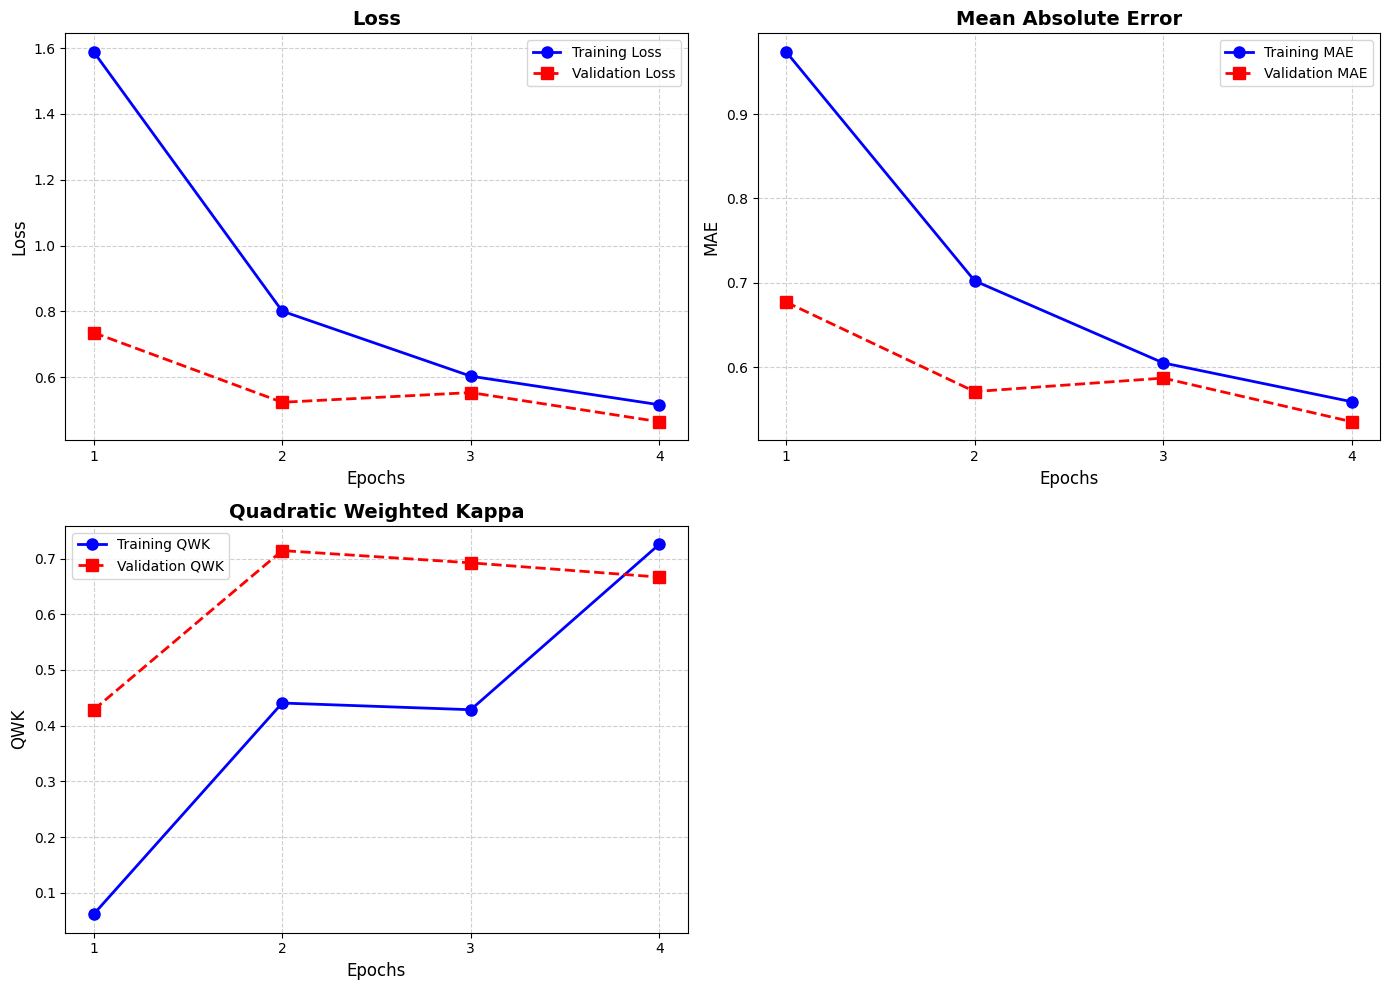

In [ ]:
# Visualisasi Data

import matplotlib.pyplot as plt

# Data training dan validation metrics untuk 4 epoch
epochs = [1, 2, 3, 4]  # Epoch menggunakan integer
history = {
    'loss': [1.5884, 0.8008, 0.6033, 0.5165],
    'val_loss': [0.7355, 0.52397, 0.5535, 0.46494],
    'mean_absolute_error': [0.9737, 0.7024, 0.6052, 0.5592],
    'val_mean_absolute_error': [0.6772, 0.5712, 0.5872, 0.5355],
    'quadratic_weighted_kappa': [0.0617, 0.4407, 0.4287, 0.7255],
    'val_quadratic_weighted_kappa': [0.4286, 0.7143, 0.6923, 0.6667]
}

# Membuat subplots untuk menampilkan grafik
plt.figure(figsize=(14, 10))  # Mengatur ukuran figure agar lebih besar

# Plot Loss (Training Loss dan Validation Loss)
plt.subplot(2, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss', marker='o', color='b', linestyle='-', markersize=8, linewidth=2)
plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='s', color='r', linestyle='--', markersize=8, linewidth=2)
plt.title('Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.xticks(epochs)  # Menampilkan epoch sebagai integer
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Mean Absolute Error (Training MAE dan Validation MAE)
plt.subplot(2, 2, 2)
plt.plot(epochs, history['mean_absolute_error'], label='Training MAE', marker='o', color='b', linestyle='-', markersize=8, linewidth=2)
plt.plot(epochs, history['val_mean_absolute_error'], label='Validation MAE', marker='s', color='r', linestyle='--', markersize=8, linewidth=2)
plt.title('Mean Absolute Error', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend()
plt.xticks(epochs)  # Menampilkan epoch sebagai integer
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Quadratic Weighted Kappa (Training QWK dan Validation QWK)
plt.subplot(2, 2, 3)
plt.plot(epochs, history['quadratic_weighted_kappa'], label='Training QWK', marker='o', color='b', linestyle='-', markersize=8, linewidth=2)
plt.plot(epochs, history['val_quadratic_weighted_kappa'], label='Validation QWK', marker='s', color='r', linestyle='--', markersize=8, linewidth=2)
plt.title('Quadratic Weighted Kappa', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('QWK', fontsize=12)
plt.legend()
plt.xticks(epochs)  # Menampilkan epoch sebagai integer
plt.grid(True, linestyle='--', alpha=0.6)

# Menata layout agar grafik tidak tumpang tindih
plt.tight_layout()

# Menampilkan grafik
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.models import load_model

# Memuat model LSTM yang telah dilatih
model_path = '/content/drive/MyDrive/Modelling Save 2/best_model_lstm.h5'
model = load_model(model_path, custom_objects={'QuadraticWeightedKappa': QuadraticWeightedKappa})

In [ ]:
# Prediksi menggunakan model pada data validasi
predictions = model.predict(X_valid_pad)

# Membulatkan nilai prediksi menjadi integer (1-6)
predicted_scores = np.round(predictions).astype(int)

# Menampilkan beberapa prediksi dan jawaban yang benar
for i in range(10):  # Tampilkan 10 contoh pertama
    print(f"Predicted: {predicted_scores[i]}, True: {y_valid[i]}")

109/109 [==============================] - 29s 269ms/step
Predicted: [3], True: 2
Predicted: [3], True: 3
Predicted: [3], True: 1
Predicted: [3], True: 3
Predicted: [3], True: 2
Predicted: [4], True: 4
Predicted: [4], True: 4
Predicted: [3], True: 3
Predicted: [2], True: 1
Predicted: [2], True: 2


In [ ]:
# Prediksi menggunakan model pada data test
test_file = '/content/dataset/test.csv'

# Memastikan file test ada
if os.path.exists(test_file):
    test = pd.read_csv(test_file)

    # Lakukan pembersihan teks pada data test
    test['clean_text'] = test['full_text'].apply(clean_text)

    # Tokenisasi teks pada data test
    X_test_seq = tokenizer.texts_to_sequences(test['clean_text'])

    # Padding urutan pada data test
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

    # Prediksi menggunakan model pada data test
    test_predictions = model.predict(X_test_pad)

    # Membulatkan nilai prediksi menjadi integer (1-6)
    predicted_test_scores = np.round(test_predictions).astype(int)

    # Menampilkan beberapa prediksi pada data test (hingga jumlah data yang ada)
    num_predictions = len(predicted_test_scores)
    for i in range(min(10, num_predictions)):  # Tampilkan maksimal 10 contoh atau sesuai jumlah prediksi
        print(f"Predicted: {predicted_test_scores[i]}")
else:
    print("Test file not found.")

1/1 [==============================] - 0s 167ms/step
Predicted: [3]
Predicted: [3]
Predicted: [4]


In [ ]:
# Memastikan file sample_submission ada
sample_submission_file = '/content/dataset/sample_submission.csv'

if os.path.exists(sample_submission_file):
    sample_submission = pd.read_csv(sample_submission_file)

    # Pastikan sample_submission memiliki kolom 'essay_id' dan 'score'
    # Gantilah kolom 'score' dengan prediksi yang sudah dibulatkan
    sample_submission['score'] = predicted_test_scores[:len(sample_submission)]  # Ambil prediksi sesuai jumlah data

    # Tampilkan beberapa baris hasil prediksi
    print(sample_submission.head())  # Menampilkan 5 baris pertama
else:
    print("Sample submission file not found.")

  essay_id  score
0  000d118      3
1  000fe60      3
2  001ab80      4
